All analysis is being done in hg38

# The goal of this script is categorize Disease Associated Variants (DAVs) into 6 different categories:

 1. DAVs found in splice sites
 2. DAVs creating new splice sites
 3. DAVs found in ISRE motifs
 4. DAVs creating new ISRE motifs
 5. DAVs flanking a certain distance from ISRE motifs
 6. DAVs that don't meet any of the above criteria

In [1]:
whichDataSet = "HGMD"

In [6]:
# Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import regex as re2
import seaborn as sns

In [3]:
chrom = range(1,23)
chrom.extend(['X','Y'])
chrom_act = ['chr'+str(i) for i in chrom]

We want to look at the distribution of DAVs along the introns. We  intersect DAVs with the introns

In [4]:
%%script bash
DataSet="HGMD"
echo $DataSet
if [ $DataSet == "All" ]
then
 filetoIntersect="CombinedMutations_HGMDandClinVar.bed" 
elif [ $DataSet == "HGMD" ]
then 
 filetoIntersect="Mutations_HGMD.bed"
else 
 filetoIntersect="Mutations_ClinVar.bed"
fi
echo $filetoIntersect
bedtools intersect -a ../processed_data/Introns_JustmRNAs.bed -b ../processed_data/${filetoIntersect} -wa -wb > ../temp/${DataSet}/Introns_Intersect_${DataSet}Muts.txt

ClinVar
Mutations_ClinVar.bed


In [5]:
# Read in the mutations that intersect
introns_Intersect_Muts = pd.read_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts.txt",sep="\t",header=None)
print introns_Intersect_Muts.shape
introns_Intersect_Muts.head()

(132025, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr1,201322133,201323012,NM_001005337,+,PKP1,chr1,201322997,201322998,294823,G,T,Likely_benign
1,chr1,201325127,201325753,NM_001005337,+,PKP1,chr1,201325742,201325743,390680,C,T,Likely_benign
2,chr1,201322133,201323012,NM_000299,+,PKP1,chr1,201322997,201322998,294823,G,T,Likely_benign
3,chr1,201325127,201325753,NM_000299,+,PKP1,chr1,201325742,201325743,390680,C,T,Likely_benign
4,chr1,8359986,8360111,NM_001042682,-,RERE,chr1,8360004,8360005,445470,C,A,Likely_benign


In [6]:
# Only do this is dataset is HGMD
if whichDataSet=="HGMD":
    introns_Intersect_Muts_SameStrand = introns_Intersect_Muts[introns_Intersect_Muts[4]==introns_Intersect_Muts[10]]
    print introns_Intersect_Muts_SameStrand.shape
    introns_Intersect_Muts = introns_Intersect_Muts_SameStrand.iloc[:,[0,1,2,3,4,5,6,7,8,9,11,12,13]]
    print introns_Intersect_Muts.head()

In [7]:
# Now mutations can overlap a few introns, especially if these introns are alternatively spliced
# Our approach is to just randomly select one intron the mutation overlaps with
# First we group by the mutation ID
introns_Intersect_Muts_SingleLocation = introns_Intersect_Muts.groupby([9]).apply(lambda x :x.iloc[np.random.randint(0, len(x))])
print introns_Intersect_Muts_SingleLocation.shape
introns_Intersect_Muts_SingleLocation.head()

(50129, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
9,,,,,,,,,,,,,
14,chr6,26092960,26093118,NM_139010,+,HFE,chr6,26093007,26093008,14,G,A,Benign
735,chr4,1096839,1108342,NM_001193318,-,RNF212,chr4,1101492,1101493,735,A,G,association
736,chr4,1081619,1085895,NM_194439,-,RNF212,chr4,1084398,1084399,736,G,A,association
986,chr6,20649377,20739518,NM_017774,+,CDKAL1,chr6,20660802,20660803,986,A,C,Uncertain_significance
987,chr6,20649377,20739518,NM_017774,+,CDKAL1,chr6,20679477,20679478,987,A,G,Uncertain_significance


In [8]:
introns_Intersect_Muts_SingleLocation_sorted = introns_Intersect_Muts_SingleLocation.sort_values(by=[0,1,2])
introns_Intersect_Muts_SingleLocation_sorted.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
9,,,,,,,,,,,,,
263166,chr1,1020373,1022200,NM_198576,+,AGRN,chr1,1022187,1022188,263166,A,G,Benign
128292,chr1,1041702,1041955,NM_001305275,+,AGRN,chr1,1041949,1041950,128292,T,C,Benign
263159,chr1,1042162,1043238,NM_001305275,+,AGRN,chr1,1042189,1042190,263159,G,A,Benign
263164,chr1,1043457,1043537,NM_198576,+,AGRN,chr1,1043475,1043476,263164,G,A,Benign
263168,chr1,1044439,1045160,NM_001305275,+,AGRN,chr1,1044454,1044455,263168,G,A,Benign


In [9]:
introns_Intersect_Muts_SingleLocation_sorted.to_csv("../temp/"+whichDataSet+"/introns_unique_Intersect_"+whichDataSet+"Muts.txt",sep="\t",header=False,index=False)

In [10]:
# This function will get the difference between start site of feature of interest and see how far it is from the start
# of the intron
def getDataForAnydistribution(data,window_5,window_3):
    data_plus = data[data[4]=='+']
    data_minus = data[data[4]=='-']
    valid_data_plus = data_plus[(data_plus[7] >= data_plus[1]+window_5) & (data_plus[7] <= data_plus[2]-1-window_3)]
    valid_data_minus = data_minus[(data_minus[7] >= data_minus[1]+window_3) & (data_minus[7] <= data_minus[2]-1-window_5)]
    data_dist_plus = (valid_data_plus[7]-valid_data_plus[1])/(valid_data_plus[2]-valid_data_plus[1])
    data_dist_minus = (valid_data_minus[7] - valid_data_minus[1]) / (valid_data_minus[2] - valid_data_minus[1])
    return pd.concat([data_dist_plus,1-data_dist_minus])

In [11]:
introns_Intersect_Muts_SingleLocation = pd.read_csv("../temp/"+whichDataSet+"/introns_unique_Intersect_"+whichDataSet+"Muts.txt",header=None,sep="\t")
introns_Muts_dist = getDataForAnydistribution(introns_Intersect_Muts_SingleLocation,0,0)
introns_Muts_dist.head()

0    0.992885
1    0.976285
2    0.025093
3    0.225000
4    0.020804
dtype: float64

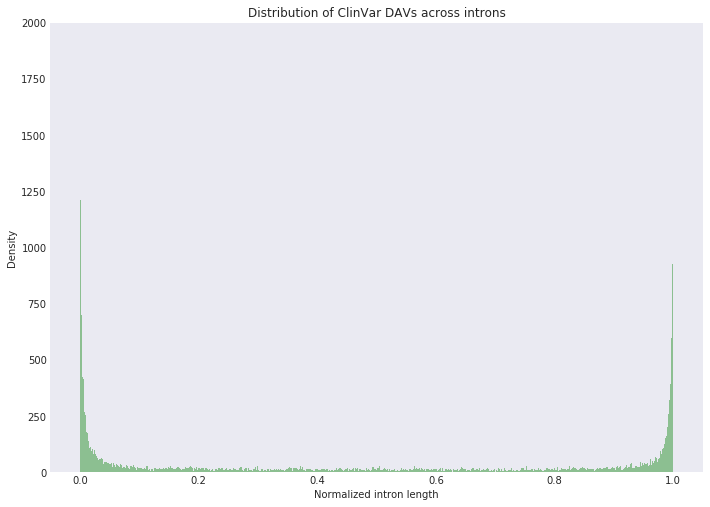

In [12]:
# Plot the distribution of mutations across introns
# Number of bins are the equal to the median length of an intron 1582
sns.set_style("dark")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(introns_Muts_dist, bins=1582, kde=False, rug=False, color="green");
plt.ylim([0,2000])
plt.ylabel('Density')
plt.xlabel('Normalized intron length')
plt.title("Distribution of "+whichDataSet+" DAVs across introns")
plt.show()

In [13]:
# We want to take a look at the distribution of mutations across introns but remove those that are within splice sites
# 5' splice site is 6 bases into intron, while 3' splice site is 34 bases into intron
introns_Muts_dist_outsideSS = getDataForAnydistribution(introns_Intersect_Muts_SingleLocation,6,34)
introns_Muts_dist_outsideSS.head()

2    0.025093
3    0.225000
4    0.020804
5    0.135802
6    0.210526
dtype: float64

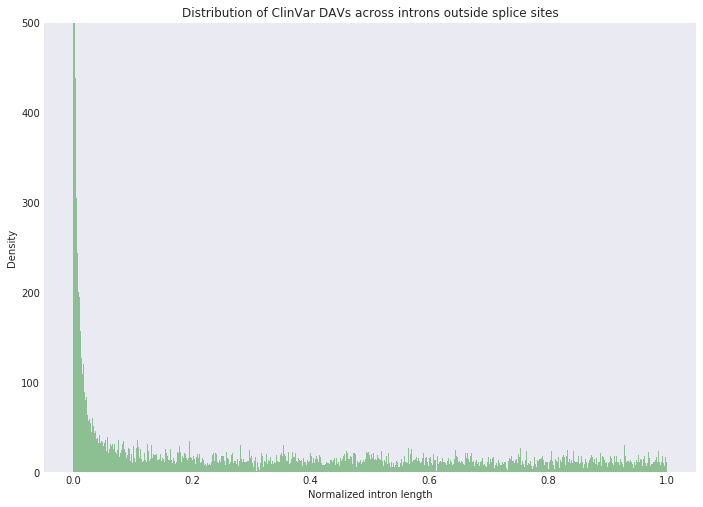

In [14]:
# Plot the distribution of mutations across introns after removing those that are 
# Number of bins are the equal to the median length of an intron 1582
sns.set_style("dark")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(introns_Muts_dist_outsideSS, bins=1582, kde=False, rug=False, color="green");
plt.ylim([0,500])
plt.ylabel('Density')
plt.xlabel('Normalized intron length')
plt.title("Distribution of "+whichDataSet+" DAVs across introns outside splice sites")
plt.show()

### This will help us with the first category: DAVs found within splice sites.

We want to separate out DAVs that are within the 5' splice site and 3' splice site, polypyramidine sites, branch point. 

In [15]:
# This function will return a list that contains three elements. One with DAVs within  5' splice sites
# One with DAVs within 3' splice sites, and One with DAVs not within splice sites
def separateMutations(data):
    data_plus = data[data[4]=='+']
    data_plus_within5p = data_plus[data_plus[7] <= data_plus[1] + 6]
    data_plus_within3p = data_plus[data_plus[7] >= data_plus[2] - 33]
    data_plus_notwithinSS = data_plus[(data_plus[7] > data_plus[1] + 6)&(data_plus[7] < data_plus[2] - 33)]
    data_minus = data[data[4]=='-']
    data_minus_within3p = data_minus[data_minus[7] <= data_minus[1] + 34]
    data_minus_within5p = data_minus[data_minus[7] >= data_minus[2] - 5]
    data_minus_notwithinSS = data_minus[(data_minus[7] > data_minus[1] + 34)&(data_minus[7] < data_minus[2] - 5)]
    return([pd.concat([data_plus_within5p,data_minus_within5p]),pd.concat([data_plus_within3p,data_minus_within3p]),pd.concat([data_plus_notwithinSS,data_minus_notwithinSS])])

In [16]:
muts_Intersect_Introns_WithinORnotSSs = separateMutations(introns_Intersect_Muts_SingleLocation)

In [58]:
muts_Intersect_Introns_WithinORnotSSs[0].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
9,chr1,1046088,1046159,NM_001305275,+,AGRN,chr1,1046094,1046095,434107,G,A,Benign/Likely_benign
17,chr1,1049059,1049235,NM_001305275,+,AGRN,chr1,1049064,1049065,474131,C,T,Benign
26,chr1,1051815,1051992,NM_001305275,+,AGRN,chr1,1051819,1051820,128317,C,T,Benign
30,chr1,2025738,2027576,NM_000815,+,GABRD,chr1,2025743,2025744,447367,C,T,Conflicting_interpretations_of_pathogenicity
41,chr1,2304585,2306019,NM_003036,+,SKI,chr1,2304590,2304591,239476,C,T,Uncertain_significance


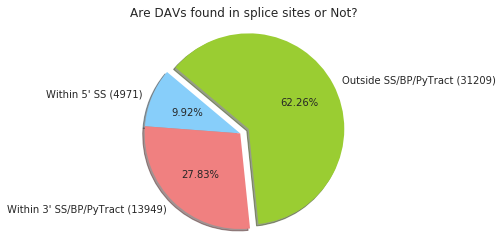

In [17]:
numMuts_5SS_introns = muts_Intersect_Introns_WithinORnotSSs[0].shape[0]
numMuts_3SS_introns = muts_Intersect_Introns_WithinORnotSSs[1].shape[0]
numMuts_nonSS_introns = muts_Intersect_Introns_WithinORnotSSs[2].shape[0]

labels = 'Within 5\' SS (' + str(numMuts_5SS_introns) + ')','Within 3\' SS/BP/PyTract (' \
    + str(numMuts_3SS_introns) + ')','Outside SS/BP/PyTract (' \
                + str(numMuts_nonSS_introns) + ')'
sizes = [numMuts_5SS_introns,numMuts_3SS_introns,numMuts_nonSS_introns]
colors = ['lightskyblue','lightcoral','yellowgreen']
explode = (0, 0,0.1)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140)
plt.title('Are DAVs found in splice sites or Not?')
plt.axis('equal')
plt.show()

In [18]:
# We want to write the mutations found in introns that are within splice sites into two files, including the
# introns in which they intersect
# We also want to write the mutations found in introns that are NOT within splice sites, including introns
muts_Intersect_Introns_WithinORnotSSs[0].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_Within5SS.txt",sep="\t",header=False,index=False)
muts_Intersect_Introns_WithinORnotSSs[1].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_Within3SS.txt",sep="\t",header=False,index=False)
muts_Intersect_Introns_WithinORnotSSs[2].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS.txt",sep="\t",header=False,index=False)


### Next we will try to categorize DAVs into the second category: DAVs creating new splice sites.

We want to find DAVs that result in a splice site motif that has a stronger strength score than the true splice site

In [19]:
# This function's purpose is to add the WT sequence and corresponding sequence including the mutation
def createDataFrameWithWTAndMUTseqs(datafile_with_seq,datafile):
    base_dict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
    # Read in the file which contains that the mut id and corresponding sequence around it
    data_with_seq = pd.read_csv(datafile_with_seq,header=None,sep="\t")
    # Capitalize the sequences 
    seqs_to_add = data_with_seq[1].str.upper()
    # Read data with muts intersecting introns, contains info on the WT base and MUT base for that mutation
    # Add sequence around mutation to that data frame
    data = pd.read_csv(datafile,header=None,sep="\t")
    data_withseqs = data.assign(seq=seqs_to_add)
    # Deal with plus strand
    # We are taking the mutant base and adding it to the WT sequence around the mutation
    data_withseqs_plus = data_withseqs[data_withseqs[4]=='+']
    mutbases_plus = data_withseqs_plus[11].values
    wt_seqs_plus = data_withseqs_plus['seq'].values
    mutated_seqs_plus = [wt_seqs_plus[i][0:25]+mutbases_plus[i]+wt_seqs_plus[i][26:] for i in range(len(wt_seqs_plus))]
    data_withseqs_plus_mutseq = data_withseqs_plus.assign(mutseq=mutated_seqs_plus )
    # Deal with minus strand
    # Same thing as above, except we have to reverse complement WT and MUT bases for the mutations
    # Sequence around the mutation was already reverse complemented when we used bedtools getfasta
    data_withseqs_minus = data_withseqs[data_withseqs[4]=='-']
    minus_WTbase_complement = data_withseqs_minus[10].map(base_dict)
    minus_MUTbase_complement = data_withseqs_minus[11].map(base_dict)
    data_withseqs_minus.loc[:,10] = minus_WTbase_complement.values
    data_withseqs_minus.loc[:,11] = minus_MUTbase_complement.values
    wt_seqs_minus = data_withseqs_minus['seq'].values
    mutated_seqs_minus = [wt_seqs_minus[i][0:25]+minus_MUTbase_complement.values[i]+wt_seqs_minus[i][26:] for i in range(len(wt_seqs_minus))]
    data_withseqs_minus_mutseq = data_withseqs_minus.assign(mutseq=mutated_seqs_minus)
    # Combine the plus and minus data, and sort that and return it
    combine_data = data_withseqs_plus_mutseq.append(data_withseqs_minus_mutseq)
    combine_data_sorted = combine_data.sort_values(by=[0,1,2])
    return combine_data_sorted

In [30]:
# We want to get a 50 bp window around the mutation to extract sequences 
muts = pd.read_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS.txt",sep="\t",header=None)
print muts.head()
muts_newdata = {"chrm":muts[0],"start":muts[7]-25,"end":muts[8]+25,"snp_id":muts[9],"strand":muts[4],"score":[0]*len(muts[8])}
muts_newdf = pd.DataFrame(muts_newdata,columns=["chrm","start","end","snp_id","score","strand"])
print muts_newdf.head()
muts_newdf.to_csv("../temp/"+whichDataSet+"/"+whichDataSet+"Muts_NotWithinSS_25bpWindow.bed",header=False,index=False,sep="\t")

     0        1        2             3  4     5     6        7        8   \
0  chr1  1042162  1043238  NM_001305275  +  AGRN  chr1  1042189  1042190   
1  chr1  1043457  1043537     NM_198576  +  AGRN  chr1  1043475  1043476   
2  chr1  1044439  1045160  NM_001305275  +  AGRN  chr1  1044454  1044455   
3  chr1  1045277  1045358     NM_198576  +  AGRN  chr1  1045288  1045289   
4  chr1  1045523  1045732  NM_001305275  +  AGRN  chr1  1045567  1045568   

       9  10 11             12  
0  263159  G  A         Benign  
1  263164  G  A         Benign  
2  263168  G  A         Benign  
3  387477  A  G  Likely_benign  
4  263171  C  T  Likely_benign  
   chrm    start      end  snp_id  score strand
0  chr1  1042164  1042215  263159      0      +
1  chr1  1043450  1043501  263164      0      +
2  chr1  1044429  1044480  263168      0      +
3  chr1  1045263  1045314  387477      0      +
4  chr1  1045542  1045593  263171      0      +


In [21]:
%%script bash
# Use bedtools to extract sequences around mutations from fasta file and write both a fasta file and a TSV file
DataSet="ClinVar"
echo $DataSet
bedtools getfasta -fi /home/shared/hg38/hg38.fa -bed ../temp/${DataSet}/${DataSet}Muts_NotWithinSS_25bpWindow.bed -name -s -fo ../temp/${DataSet}/${DataSet}Muts_NotWithinSS_25bpWindow-Sequences.fa
bedtools getfasta -fi /home/shared/hg38/hg38.fa -bed ../temp/${DataSet}/${DataSet}Muts_NotWithinSS_25bpWindow.bed -name -s -tab -fo ../temp/${DataSet}/${DataSet}Muts_NotWithinSS_25bpWindow-Sequences.txt

ClinVar


In [22]:
introns_Intersect_muts_nonSS_WTandMUTseqs = createDataFrameWithWTAndMUTseqs("../temp/"+whichDataSet+"/"+whichDataSet+"Muts_NotWithinSS_25bpWindow-Sequences.txt","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS.txt")
introns_Intersect_muts_nonSS_WTandMUTseqs.head()

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,0,1,2,3,4,5,6,7,8,9,10,11,12,seq,mutseq
0,chr1,1042162,1043238,NM_001305275,+,AGRN,chr1,1042189,1042190,263159,G,A,Benign,GAGCGCCCCGGGGTGGAGGCCAGGCGGGGTGGGCTGCTCCTGCGTC...,GAGCGCCCCGGGGTGGAGGCCAGGCAGGGTGGGCTGCTCCTGCGTC...
1,chr1,1043457,1043537,NM_198576,+,AGRN,chr1,1043475,1043476,263164,G,A,Benign,CCCTGTGGTCAGTGGCGGGTGAGGGGTCTGGTGGGGGTCGGGGAGA...,CCCTGTGGTCAGTGGCGGGTGAGGGATCTGGTGGGGGTCGGGGAGA...
2,chr1,1044439,1045160,NM_001305275,+,AGRN,chr1,1044454,1044455,263168,G,A,Benign,GCCTGCCGAGGTGAGCCGGCTGCACGTGGGGTCTCAGGCACAGGCG...,GCCTGCCGAGGTGAGCCGGCTGCACATGGGGTCTCAGGCACAGGCG...
3,chr1,1045277,1045358,NM_198576,+,AGRN,chr1,1045288,1045289,387477,A,G,Likely_benign,GGCTGGCTGCCCCAGTGAGTACCTGAGCTCAGCCCCGACCCCGGGC...,GGCTGGCTGCCCCAGTGAGTACCTGGGCTCAGCCCCGACCCCGGGC...
4,chr1,1045523,1045732,NM_001305275,+,AGRN,chr1,1045567,1045568,263171,C,T,Likely_benign,ACTGGCCACCGGCTATGCCCTCCTACCTGTTCACCCCCATCACTGT...,ACTGGCCACCGGCTATGCCCTCCTATCTGTTCACCCCCATCACTGT...


In [23]:
# We need to check if any of the sequences across mutations contains Ns
# If they do, we need to remove those mutations, we cannot calculate splice site strength using MaxEntScan if there are Ns
any_Ns = introns_Intersect_muts_nonSS_WTandMUTseqs[introns_Intersect_muts_nonSS_WTandMUTseqs['seq'].str.contains('N')]
any_Ns.shape
# It looks like there no mutations with Ns

(0, 15)

In [24]:
introns_Intersect_muts_nonSS_WTandMUTseqs.to_csv("../temp/"+whichDataSet+"/"+"Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS-25bp_WTandMUTsequences.txt",sep="\t",header=False,index=False)

We need to grab the true splice site sequence near the mutations, because we need to compare the splice site strength of true splice site to that created by the mutation

In [25]:
import pandas as pd
def getTrueSpliceSiteCoordsClosestToMut(intersectingfile, end, writefile):

    # Grab all the mutations in the intersecting file with all column values
    allmuts = pd.read_csv(intersectingfile,header=None,sep="\t")

    allmust_plus = allmuts[allmuts[4]=="+"]
    allmust_minus = allmuts[allmuts[4]=="-"]

    if end=="5p":
        print end
        allmuts_data = {"chrom":pd.concat([allmust_plus[0],allmust_minus[0]]),
                           "start":pd.concat([allmust_plus[1]-3,allmust_minus[2]-6]),
                           "end":pd.concat([allmust_plus[1]+6,allmust_minus[2]+3]),
                           "snp_id":pd.concat([allmust_plus[9],allmust_minus[9]]),
                           "strand":pd.concat([allmust_plus[4],allmust_minus[4]]),
                        "score":[0]*len(pd.concat([allmust_plus[9],allmust_minus[9]]))}
    else:
        print end
        allmuts_data = {"chrom": pd.concat([allmust_plus[0], allmust_minus[0]]),
                           "start": pd.concat([allmust_plus[2] - 20, allmust_minus[1] - 3]),
                           "end": pd.concat([allmust_plus[2] + 3, allmust_minus[1] + 20]),
                           "snp_id": pd.concat([allmust_plus[9], allmust_minus[9]]),
                           "strand": pd.concat([allmust_plus[4], allmust_minus[4]]),
                        "score":[0]*len(pd.concat([allmust_plus[9],allmust_minus[9]]))}

    allmuts_df = pd.DataFrame(allmuts_data,columns=["chrom","start","end","snp_id","score","strand"])

    allmuts_df.to_csv(writefile,header=False,index=False,sep="\t")

In [26]:
getTrueSpliceSiteCoordsClosestToMut("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS.txt","5p","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS_5pTrueSpliceSites-Coordinates.bed")
getTrueSpliceSiteCoordsClosestToMut("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS.txt","3p","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS_3pTrueSpliceSites-Coordinates.bed")

5p
3p


In [27]:
%%script bash
# Use bedtools to extract sequences around mutations from fasta file and write both a fasta file and a TSV file
DataSet="ClinVar"
echo $DataSet
# Let's get the fasta sequences around the true splice site
bedtools getfasta -fi /home/shared/hg38/hg38.fa -bed ../temp/${DataSet}/Introns_Intersect_${DataSet}Muts_NotWithinSS_5pTrueSpliceSites-Coordinates.bed -name -s -fo ../temp/${DataSet}/Introns_Intersect_${DataSet}Muts_NotWithinSS_5pTrueSpliceSites-Sequences.fa
bedtools getfasta -fi /home/shared/hg38/hg38.fa -bed ../temp/${DataSet}/Introns_Intersect_${DataSet}Muts_NotWithinSS_3pTrueSpliceSites-Coordinates.bed -name -s -fo ../temp/${DataSet}/Introns_Intersect_${DataSet}Muts_NotWithinSS_3pTrueSpliceSites-Sequences.fa
# Using MaxEntScore to get the splice site strength of the true splice sites
score5.pl ../temp/${DataSet}/Introns_Intersect_${DataSet}Muts_NotWithinSS_5pTrueSpliceSites-Sequences.fa > ../temp/${DataSet}/Introns_Intersect_${DataSet}Muts_NotWithinSS_5pTrueSpliceSites-Sequences_MaxEntScores.txt
score3.pl ../temp/${DataSet}/Introns_Intersect_${DataSet}Muts_NotWithinSS_3pTrueSpliceSites-Sequences.fa > ../temp/${DataSet}/Introns_Intersect_${DataSet}Muts_NotWithinSS_3pTrueSpliceSites-Sequences_MaxEntScores.txt

ClinVar


In [36]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
import subprocess
# This is the function that gets all the possible splice strengths for a mutation 
def generateStrengthsOfNewSpliceSites(datafile,truesplicesitescore_file,end,writefile):
    # This data file contains the WT and MUT sequences around the mutation
    data = pd.read_csv(datafile,header=None,sep="\t")
    # This is the file that contains all the splice strengths score calculated by MaxEntScore for true splice sites
    truess_score_data = pd.read_csv(truesplicesitescore_file,header=None,sep="\t")
    # we add this true splice site strength data to the above data, since we are always going to compare to this score
    data.insert(data.shape[1],data.shape[1],truess_score_data[1].values)
    snpids = data[9].values
    #wt_seqs = data[13].values
    mut_seqs = data[14].values
    print mut_seqs[0]
    if end=='5p':
        numToAdd = 9
    else:
        numToAdd = 23
        #plus_data = data[data[4]=='+']
        #minus_data = data[data[4]=='-']
    for i in range(0, numToAdd):
        #print i
            #new_df = pd.DataFrame({"chrom":data[5],"start":data[6]-i,"end":data[6]-i+8,"snp_id":data[8],
            #                            "score":[0]*len(data[8]),"strand":data[4]},
            #                           columns= ["chrm","start","end","snp_id","score","strand"])
            #new_df.to_csv("WT_data_calcMaxEnt.bed",sep="\t",header=False,index=False)
            #pipe_out = subprocess.call(["bedtools","getfasta","-fi","/home/shared/hg38/hg38.fa","-bed","WT_data_calcMaxEnt.bed","-name","-s","fo","WT_data_calcMaxEnt-Sequences.fa"])
        #wtseqs_to_write = [SeqRecord(Seq(wt_seqs[j][25-i:25-i+numToAdd],IUPAC.unambiguous_dna), id= snpids[i] + "_WT") for j in range(len(wt_seqs))]
        mutseqs_to_write = []
        for j in range(len(mut_seqs)):
            #print j
            #print mut_seqs[j][(25-i):(25-i+numToAdd)]
            mutseqs_to_write.append(SeqRecord(Seq(mut_seqs[j][(25-i):(25-i+numToAdd)],IUPAC.unambiguous_dna), id= str(snpids[i]) + "_MUT"))
        #SeqIO.write(wtseqs_to_write,"WT_data_calcMaxEnt-Sequences.fa",'fasta')
        SeqIO.write(mutseqs_to_write,"MUT_data_calcMaxEnt-Sequences.fa",'fasta')
        #with open('WT_data_calcMaxEnt-Sequences_MaxEntScores.txt', "w") as outfileWT:
        #    subprocess.call(["score5.pl","WT_data_calcMaxEnt-Sequences.fa"],stdout=outfileWT)
        with open('MUT_data_calcMaxEnt-Sequences_MaxEntScores.txt',"w") as outfileMUT:
            if end=='5p':
                subprocess.call(["score5.pl","MUT_data_calcMaxEnt-Sequences.fa"],stdout=outfileMUT)
            else:
                subprocess.call(["score3.pl","MUT_data_calcMaxEnt-Sequences.fa"],stdout=outfileMUT)
            #pipe_out = subprocess.call(["bedtools","getfasta","-fi","/home/shared/hg38/hg38.fa","-bed","WT_data_calcMaxEnt.bed","-name","-s","-tab","fo","WT_data_calcMaxEnt-Sequences.bed"])
        #wt_maxentdata_df = pd.read_csv("WT_data_calcMaxEnt-Sequences_MaxEntScores.txt",header=None,sep="\t")
        mut_maxentdata_df = pd.read_csv("MUT_data_calcMaxEnt-Sequences_MaxEntScores.txt",header=None,sep="\t")
        #data.insert(data.shape[1],data.shape[1],wt_maxentdata_df[1].values)
        data.insert(data.shape[1],data.shape[1],mut_maxentdata_df[1].values)
    
    data.to_csv(writefile,header=False,index=False,sep="\t")

In [37]:
print "Calculating splice strength of 5 SS"
generateStrengthsOfNewSpliceSites("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS-25bp_WTandMUTsequences.txt","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS_5pTrueSpliceSites-Sequences_MaxEntScores.txt","5p","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS_5p_AllMaxEntScores.txt")
print "Calculating splice strength of 3 SS"
generateStrengthsOfNewSpliceSites("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS-25bp_WTandMUTsequences.txt","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS_3pTrueSpliceSites-Sequences_MaxEntScores.txt","3p","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS_3p_AllMaxEntScores.txt")

Calculating splice strength of 5 SS
GAGCGCCCCGGGGTGGAGGCCAGGCAGGGTGGGCTGCTCCTGCGTCAGTCC
Calculating splice strength of 3 SS
GAGCGCCCCGGGGTGGAGGCCAGGCAGGGTGGGCTGCTCCTGCGTCAGTCC


In [38]:
# This is the function which identifies any mutations that are predicted to create new splice sites
# based on their splice site strength comparison to true splice site
def identifyMutsWhichCreateSpliceSites(datafile,end):
    data = pd.read_csv(datafile,sep="\t",header=None)
    #print data.head()
    snps_withSSscore_greaterThanZeroAndTrueSS = []
    if end == '5p':
        lastindex = 25
    else:
        lastindex = 39
    for i in range(16,lastindex):
        snps_withSSscore_greaterThanZeroAndTrueSS.extend(data[(data[i]>0)&(data[i]>data[15])][9].values)
    return list(set(snps_withSSscore_greaterThanZeroAndTrueSS))

In [39]:
# Get all mutations predicted to create 5' or 3' splice sites
muts_createSS_5p = identifyMutsWhichCreateSpliceSites("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS_5p_AllMaxEntScores.txt","5p")
muts_createSS_3p = identifyMutsWhichCreateSpliceSites("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS_3p_AllMaxEntScores.txt","3p")

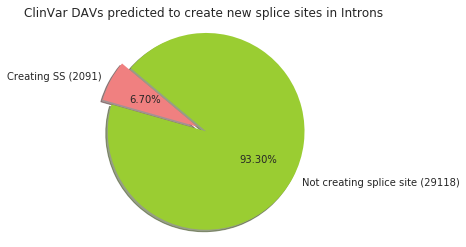

In [40]:
introns_Intersect_muts_nonSS = pd.read_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS.txt",header=None,sep="\t")
numMuts_introns_creatingBoth5p3pSS = len([i for i in muts_createSS_5p if i in muts_createSS_3p])
numMuts_introns_creatingOnly5pSS = len([i for i in muts_createSS_5p if i not in muts_createSS_3p])
numMuts_introns_creatingOnly3pSS = len([i for i in muts_createSS_3p if i not in muts_createSS_5p])
numMuts_introns_Notcreating5p3pSS = introns_Intersect_muts_nonSS.shape[0] - (numMuts_introns_creatingBoth5p3pSS + numMuts_introns_creatingOnly5pSS + numMuts_introns_creatingOnly3pSS)
labels = 'Creating SS (' + str(numMuts_introns_creatingOnly5pSS+numMuts_introns_creatingOnly3pSS+numMuts_introns_creatingBoth5p3pSS) + ')','Not creating splice site (' + str(numMuts_introns_Notcreating5p3pSS)+')'
sizes = [numMuts_introns_creatingOnly5pSS+numMuts_introns_creatingOnly3pSS+numMuts_introns_creatingBoth5p3pSS,numMuts_introns_Notcreating5p3pSS]
colors = ['lightcoral','yellowgreen']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140)
plt.title(whichDataSet+' DAVs predicted to create new splice sites in Introns')
plt.axis('equal')
plt.show()

In [41]:
# Lets write all the mutations predicted to create new splice sites in files
muts_createSS = list(set(muts_createSS_5p+muts_createSS_3p))
introns_Intersect_Muts_createSS = introns_Intersect_muts_nonSS[introns_Intersect_muts_nonSS[9].isin(muts_createSS)]
print introns_Intersect_Muts_createSS.shape
introns_Intersect_Muts_createSS.to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_CreateSS.txt",sep="\t",header=False,index=False)
introns_Intersect_Muts_createSS.head()

(2091, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
11,chr1,1050037,1050232,NM_198576,+,AGRN,chr1,1050065,1050066,263191,G,T,Benign
33,chr1,2558468,2559822,NM_003820,+,TNFRSF14,chr1,2559621,2559622,133409,G,A,not_provided
36,chr1,2558468,2559822,NM_003820,+,TNFRSF14,chr1,2559651,2559652,133412,G,A,not_provided
66,chr1,10618417,10623018,NM_004565,+,PEX14,chr1,10618430,10618431,95145,A,T,Benign
88,chr1,11787493,11787872,NM_001010881,+,C1orf167,chr1,11787633,11787634,292179,C,T,Uncertain_significance


In [42]:
# Lets write all the mutations that are not predicted to create new splice sites in files
introns_Intersect_Muts_DoesNotcreateSS = introns_Intersect_muts_nonSS[~introns_Intersect_muts_nonSS[9].isin(muts_createSS)]
print introns_Intersect_Muts_DoesNotcreateSS.shape
introns_Intersect_Muts_DoesNotcreateSS.to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_DoesNotCreateSS.txt",sep="\t",header=False,index=False)
introns_Intersect_Muts_DoesNotcreateSS.head()

(29118, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr1,1042162,1043238,NM_001305275,+,AGRN,chr1,1042189,1042190,263159,G,A,Benign
1,chr1,1043457,1043537,NM_198576,+,AGRN,chr1,1043475,1043476,263164,G,A,Benign
2,chr1,1044439,1045160,NM_001305275,+,AGRN,chr1,1044454,1044455,263168,G,A,Benign
3,chr1,1045277,1045358,NM_198576,+,AGRN,chr1,1045288,1045289,387477,A,G,Likely_benign
4,chr1,1045523,1045732,NM_001305275,+,AGRN,chr1,1045567,1045568,263171,C,T,Likely_benign


In [43]:
# Lets write the mutations themselves into a separate file
introns_Intersect_Muts_DoesNotcreateSS.iloc[:,[6,7,8,9,10,11,12,4]].to_csv("../temp/"+whichDataSet+"/"+whichDataSet+"Muts_Intersect_Introns_DoesNotCreateSS.txt",sep="\t",header=False,index=False)

### We want to look for Category 3 and Category 4 of DAVs: mutations that destroy ISREs and ones that result in new ISRE motifs being created.

Look at all mutations that are not predicted to create splice sites and identify ones that result in new ISRE motifs or destroy new ISRE motifs

In [4]:
# This is a function that will find mutations that will create or destroy ISRE motifs
def getMutationsThatCreateOrDestroyISREMotifs(ISREfile, mutation_seqfile, mutationsOfInterest, mutsite, create):
    # Open the file containing ISRE motifs
    ISRE_motifs = pd.read_csv(ISREfile,header=None)
    print ISRE_motifs.head()
    # Open file with mutations and sequences surrounding mutations
    mutations_withSeq = pd.read_csv(mutation_seqfile,sep="\t",header=None)
    print mutations_withSeq.shape
    # Open file that contains IDs of mutations of interest
    muts_Of_interest = pd.read_csv(mutationsOfInterest,sep="\t",header=None)
    print muts_Of_interest.shape
    
    # Subset muations_withSeq data and only have ones that contains IDs of mutations of interest
    muts_Of_interest_withSeq = mutations_withSeq[mutations_withSeq[9].isin(muts_Of_interest[9])]
    print muts_Of_interest_withSeq.shape
    
    if create == True:
        index_for_seq = 14
    else:
        index_for_seq = 13
    
    # Create a dictionary that stores the mutated sequence as values with mutation id as the key
    muts_dict = pd.Series(muts_Of_interest_withSeq[index_for_seq].values,index=muts_Of_interest_withSeq[9].values).to_dict()
    
    # These are the lists that are going to contain the mutation ids for mutations that result in new ISRE motifs
    mutations_Have_Motifs = []

    # Go through every record in mutation file
    for mut in muts_dict.keys():
        mut_seq = muts_dict[mut]
        mutatedISREmotifs_for_mut = []
        for i in ISRE_motifs[0].values:
            x = [[m.start(), m.end()] for m in re2.finditer(i, mut_seq,overlapped=True) if mutsite in range(m.start(), m.end())]
            if len(x) != 0:
                mutatedISREmotifs_for_mut.append(i)
        if len(mutatedISREmotifs_for_mut) > 0:
            mutations_Have_Motifs.append([mut,mutatedISREmotifs_for_mut])

    return mutations_Have_Motifs

In [5]:
# Look for ISRE motifs in the sequences around the mutation that contain the mutated base and check if the mutated base
# is within the ISRE motif found
Muts_Create_New_ISREs = getMutationsThatCreateOrDestroyISREMotifs("../data/ISE_ISS_ZWpaper.tsv","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS-25bp_WTandMUTsequences.txt","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_DoesNotCreateSS.txt",25,True)
print len(Muts_Create_New_ISREs)
Muts_Create_New_ISREs[0:5]

        0
0  ACATGA
1  GTAACG
2  ACATGG
3  GGAACC
4  AGATAG
(7742, 15)
(7124, 13)
(7124, 15)
1299


[['CM076556', ['TTGTGG']],
 ['CS128048', ['AGAGGT']],
 ['CM077979', ['TGTGGG']],
 ['CM990806', ['AGTGTG']],
 ['CS1513479', ['AGTTAA']]]

In [13]:
# Look for ISRE motifs in the sequences around the mutation that contain the WT base and check if the WT base
# is within the ISRE motif found
Muts_Destroy_ISREs = getMutationsThatCreateOrDestroyISREMotifs("../data/ISE_ISS_ZWpaper.tsv","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotWithinSS-25bp_WTandMUTsequences.txt","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_DoesNotCreateSS.txt",25,False)
print len(Muts_Destroy_ISREs)

        0
0  ACATGA
1  GTAACG
2  ACATGG
3  GGAACC
4  AGATAG
(7742, 15)
(7124, 13)
(7124, 15)
1255


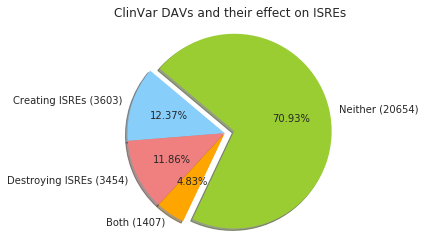

In [47]:
# Piechart to show how DAVs addect ISRE motifs
introns_Intersect_Muts_DoesNotcreateSS = pd.read_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_DoesNotCreateSS.txt",header=None,sep="\t")
Muts_NotcreatingdestroyingISREs = [i for i in list(introns_Intersect_Muts_DoesNotcreateSS[9].values) if i not in Muts_Create_New_ISREs and i not in Muts_Destroy_ISREs]
Muts_BothcreatingdestroyingISREs = [i for i in Muts_Create_New_ISREs if i in Muts_Destroy_ISREs]
Muts_JustcreatingISREs = [i for i in Muts_Create_New_ISREs if i not in Muts_Destroy_ISREs]
Muts_JustdestroyingISREs = [i for i in Muts_Destroy_ISREs if i not in Muts_Create_New_ISREs]

labels = 'Creating ISREs (' + str(len(Muts_JustcreatingISREs)) + ')', \
    'Destroying ISREs (' + str(len(Muts_JustdestroyingISREs))+')', \
    'Both (' + str(len(Muts_BothcreatingdestroyingISREs))+')', \
    'Neither (' + str(len(Muts_NotcreatingdestroyingISREs))+')'
sizes = [len(Muts_JustcreatingISREs),len(Muts_JustdestroyingISREs),len(Muts_BothcreatingdestroyingISREs),len(Muts_NotcreatingdestroyingISREs)]
colors = ['lightskyblue','lightcoral','orange','yellowgreen']
explode = (0, 0,0,0.1)  # explode last slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140)
plt.title(whichDataSet+' DAVs and their effect on ISREs')
plt.axis('equal')
plt.show()

In [48]:
# We want to write these mutations into files 
introns_Intersect_Muts_DoesNotcreateSS[introns_Intersect_Muts_DoesNotcreateSS[9].isin(Muts_BothcreatingdestroyingISREs)].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_BothCreateDestroyISRE.txt",sep="\t",header=False,index=False)
introns_Intersect_Muts_DoesNotcreateSS[introns_Intersect_Muts_DoesNotcreateSS[9].isin(Muts_NotcreatingdestroyingISREs)].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotCreateDestroyISRE.txt",sep="\t",header=False,index=False)
introns_Intersect_Muts_DoesNotcreateSS[introns_Intersect_Muts_DoesNotcreateSS[9].isin(Muts_JustcreatingISREs)].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_JustCreateISRE.txt",sep="\t",header=False,index=False)
introns_Intersect_Muts_DoesNotcreateSS[introns_Intersect_Muts_DoesNotcreateSS[9].isin(Muts_JustdestroyingISREs)].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_JustDestroyISRE.txt",sep="\t",header=False,index=False)

In [49]:
# We need to grab just the mutations that are not creating or destroying ISREs and write that to a file
introns_Intersect_Muts_DoesNotcreateSS[introns_Intersect_Muts_DoesNotcreateSS[9].isin(Muts_NotcreatingdestroyingISREs)].iloc[:,[6,7,8,9,4,10,11,12]].to_csv("../temp/"+whichDataSet+"/"+whichDataSet+"Muts_Intersect_Introns_NotCreateDestroyISRE.txt",sep="\t",index=False,header=False)

### We focus on next category of DAVs to assign: DAVs that are found flanking 100bp around ISREs.  

We first intersect the DAVs with 100bp flanking ISREs. 

Data for 100bp flanking ISREs coordinates comes from script Analyzing distribution of ISREs within introns.ipynb

In [50]:
%%script bash
# Use bedtools to extract sequences around mutations from fasta file and write both a fasta file and a TSV file
DataSet="ClinVar"
echo $DataSet
# Intersect DAVs that are not creating or destroying ISREs with 100bp around ISREs
bedtools intersect -a ../processed_data/ISREs_Intersect_Introns_singleISRElocation_50bpWindow.bed -b ../temp/${DataSet}/${DataSet}Muts_Intersect_Introns_NotCreateDestroyISRE.txt -wa -wb > ../temp/${DataSet}/ISREs_Intersect_${DataSet}Muts_Intersect_Introns.txt

ClinVar


In [51]:
# Read in the intersection data
ISREs_Intersect_introns_Intersect_muts = pd.read_csv("../temp/"+whichDataSet+"/ISREs_Intersect_"+whichDataSet+"Muts_Intersect_Introns.txt",sep="\t",header=None)
print ISREs_Intersect_introns_Intersect_muts.shape
ISREs_Intersect_introns_Intersect_muts.head()

(72316, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr1,1045542,1045648,CTCCTC,+,chr1,1045567,1045568,263171,+,C,T,Likely_benign
1,chr1,1047442,1047548,TCCTCC,+,chr1,1047463,1047464,128301,+,G,C,Benign/Likely_benign
2,chr1,1049986,1050092,GGTCGG,+,chr1,1050053,1050054,263190,+,T,A,Likely_benign
3,chr1,1049996,1050102,GTGGGG,+,chr1,1050053,1050054,263190,+,T,A,Likely_benign
4,chr1,1050012,1050118,AGGGGG,+,chr1,1050053,1050054,263190,+,T,A,Likely_benign


In [52]:
# Sanity check to see how many mutations we are intersecting, should be same number in piechart
print ISREs_Intersect_introns_Intersect_muts.iloc[:,8].drop_duplicates().shape[0]

17812


In [53]:
# We only want to include mutations found in introns on the same strand as the ISREs
ISREs_Intersect_introns_Intersect_muts_SameStrand = ISREs_Intersect_introns_Intersect_muts[ISREs_Intersect_introns_Intersect_muts[4]==ISREs_Intersect_introns_Intersect_muts[9]]
print ISREs_Intersect_introns_Intersect_muts_SameStrand.shape

(71596, 13)


In [54]:
# Write these mutations to a file
ISREs_Intersect_introns_Intersect_muts_SameStrand.to_csv("../temp/"+whichDataSet+"/"+whichDataSet+"Muts_Flanking_100bpISREs.txt",sep="\t",header=False,index=False)

This is the last category of DAVs: They don't meet any of the above criteria -> not found in SS, don't create splice sites, not found in ISREs, don't create new ISREs, not flanking 100 bp around ISREs

In [55]:
# Get mutations that are not found flanking ISREs and don't meet any of above categories
Muts_NotCreatingDestroyingISREs = pd.read_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_NotCreateDestroyISRE.txt",sep="\t",header=None)
Muts_NotMeetingAnyCriteria = Muts_NotCreatingDestroyingISREs[~Muts_NotCreatingDestroyingISREs[9].isin(ISREs_Intersect_introns_Intersect_muts_SameStrand[8])]
print Muts_NotMeetingAnyCriteria.shape
Muts_NotMeetingAnyCriteria.head()

(2868, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr1,1045277,1045358,NM_198576,+,AGRN,chr1,1045288,1045289,387477,A,G,Likely_benign
3,chr1,1049059,1049235,NM_198576,+,AGRN,chr1,1049075,1049076,387479,C,T,Benign
42,chr1,11785289,11787387,NM_001010881,+,C1orf167,chr1,11785779,11785780,292148,G,A,Uncertain_significance
43,chr1,11785289,11787387,NM_001010881,+,C1orf167,chr1,11785795,11785796,292149,G,C,Uncertain_significance
44,chr1,11785289,11787387,NM_001010881,+,C1orf167,chr1,11785881,11785882,292150,G,A,Uncertain_significance


In [56]:
Muts_NotMeetingAnyCriteria.to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"Muts_DoNotMeetAnyCriteria.txt",sep="\t",header=False,index=False)

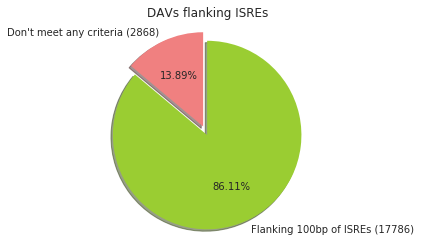

In [57]:
labels = "Flanking 100bp of ISREs (" + str(ISREs_Intersect_introns_Intersect_muts_SameStrand[8].drop_duplicates().shape[0]) +')', \
"Don't meet any criteria (" + str(Muts_NotMeetingAnyCriteria[9].drop_duplicates().shape[0]) + ')'
sizes = [ISREs_Intersect_introns_Intersect_muts_SameStrand[8].drop_duplicates().shape[0], \
         Muts_NotMeetingAnyCriteria[9].drop_duplicates().shape[0]]
colors = ['yellowgreen','lightcoral',]
explode = (0.1,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140)
plt.title('DAVs flanking ISREs')
plt.axis('equal')
plt.show()